In [40]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_ollama import ChatOllama

llm= ChatGroq(model='llama-3.1-8b-instant') 

In [41]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
import operator
from typing import Annotated, List

In [42]:
# schema for structured output to use in planning
class Section(BaseModel):
    name: str=Field(description='Name for this section of the report')
    description: str=Field(description='Brief Overview of the main topics and concepts of the section')

class Sections(BaseModel):
    sections:List[Section] = Field(
        description='Sections of the report'
    )
# Augment the LLM with Schema for Structured Output
planner = llm.with_structured_output(Sections)

# Creating Workers Dynamically In Langgraph
## Overview
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input.

## Worker State Management
Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output.

## Implementation
As you can see below, we iterate over a list of sections and Send each to a worker node.

In [43]:
from langgraph.constants import Send

# Graph State
class State(TypedDict):
    topic:str # report topic
    sections:List[Section] # sections of the report
    completed_sections: Annotated[
        list, operator.add 
    ]# add workers write to this key in parallel
    final_report: str # final report
    

    
# worker state
class WorkerState(TypedDict):
    section:Section # section to write
    completed_sections: Annotated[list, operator.add] 

In [44]:
# nodes

def orchestrator(state):
    """Orchestrator that generates a plan for the report"""

    report_sections = planner.invoke(
        [
            SystemMessage(
                content='Generate a plan for the report'
            ),
            HumanMessage(
                content=f'Here is the report topic: {state['topic']}'
            )
        ]
    )
    print('report_sections',report_sections)
    return {'sections':report_sections.sections}


def llm_call(state: WorkerState):
    """Write a section of the report"""
    result = llm.invoke(
        [
            SystemMessage(
                content='Write a report section following the provided name and description. Include no preamble for each section'
            ),
            HumanMessage(
                content=f'Here is the section name : {state['section'].name} and description: {state['section'].description}'
            )
        ]
    )
    return {'completed_sections':[result.content]}


# conditional edge function to create llm_call workers that each write a section of the report 
def assign_workers(state:State):
    """Assign a worker to each section in the plan"""

    # kick off section writing in parallel via send() API
    return [ Send('llm_call',{'section':section}) for section in state['sections']]



def synthesizer(state:State):
    """Synthesize full report from sections"""
    # list of completed Sections
    completed_sections = state['completed_sections']
    # synthesize full report
    report = "\n\n---\n\n".join(completed_sections)
    return {'final_report':report}
    

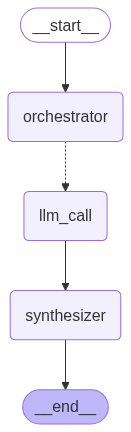

In [45]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
graph = StateGraph(State)

#add nodes

graph.add_node('orchestrator', orchestrator)
graph.add_node('llm_call',llm_call)
graph.add_node('synthesizer',synthesizer)

#add edges
graph.add_edge(START, 'orchestrator')
graph.add_conditional_edges(
    'orchestrator',
    assign_workers, 
    ['llm_call']
)
graph.add_edge('llm_call', 'synthesizer')
graph.add_edge('synthesizer', END)

graph = graph.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [50]:
# invoke
state = graph.invoke(
    {
        'topic':'create a report on Agentic AI RAGs'
    }
)



report_sections sections=[Section(name='Executive Summary', description='Overview of the key points related to Agentic AI RAGs'), Section(name='Introduction', description='Basic definition and background information about Agentic AI RAGs'), Section(name='Agentic AI RAGs Definition', description='Detailed explanation of what Agentic AI RAGs are and how they work'), Section(name='Benefits of Agentic AI RAGs', description='Discussion of the advantages of using Agentic AI RAGs'), Section(name='Challenges of Implementing Agentic AI RAGs', description='Discussion of the difficulties that may arise when implementing Agentic AI RAGs'), Section(name='Future Outlook', description='Discussion of the potential future developments and applications of Agentic AI RAGs'), Section(name='Conclusion', description='Summary of the key points related to Agentic AI RAGs')]


In [51]:
from IPython.display import Markdown
Markdown(state['final_report'])

**Executive Summary: Agentic AI RAGs**

**Key Points:**

1. **Definition of Agentic AI RAGs**: Agentic AI RAGs (Red, Amber, Green) are a framework for assessing the readiness of AI systems to perform tasks autonomously. This framework helps organizations evaluate the level of autonomy and decision-making capabilities of AI systems.

2. **Current Status**: Our current assessment indicates that most AI systems are still in the Red category, with significant limitations in their ability to make decisions and take actions independently.

3. **Challenges and Risks**: The primary challenges and risks associated with Agentic AI RAGs include the lack of transparency, accountability, and explainability in AI decision-making processes. This can lead to potential biases, errors, and unintended consequences.

4. **Recommendations**: To move AI systems from the Red category to the Amber or Green category, we recommend the following:
	* Implementing transparent and explainable AI decision-making processes.
	* Developing robust testing and validation protocols to ensure AI systems can handle complex situations.
	* Establishing clear accountability and governance frameworks for AI decision-making.

5. **Future Outlook**: As AI technology continues to evolve, we expect to see significant advancements in Agentic AI RAGs. However, it is crucial to address the challenges and risks associated with these systems to ensure their safe and effective deployment.

6. **Action Plan**: Our team will continue to monitor and assess the readiness of AI systems using the Agentic AI RAGs framework. We will also work with stakeholders to develop and implement strategies for addressing the challenges and risks associated with these systems.

---

**Introduction and Description: Basic Definition and Background Information about Agentic AI RAGs**

**Definition and Scope**

Agentic AI RAGs, short for Reasonable and Accountable Goals (RAGs), refer to a subset of artificial intelligence (AI) systems that exhibit autonomous goal-directed behavior while maintaining accountability and transparency. These AI systems are designed to navigate complex environments, make decisions, and achieve objectives in a way that aligns with human values and societal norms.

**Background and History**

The concept of Agentic AI RAGs has its roots in the field of artificial general intelligence (AGI), which aims to create AI systems that possess human-like intelligence, including reasoning, problem-solving, and learning capabilities. The development of Agentic AI RAGs draws from various disciplines, including cognitive science, computer science, and philosophy of mind. Researchers have been exploring the design of AI systems that can learn from experience, adapt to new situations, and make decisions that are aligned with human values.

**Key Characteristics and Features**

Agentic AI RAGs are designed to possess the following key characteristics and features:

1. **Autonomy**: The ability to operate independently and make decisions without human intervention.
2. **Goal-directed behavior**: The capacity to set and pursue goals, including the ability to adapt to changing circumstances.
3. **Reasoning and problem-solving**: The ability to reason, learn, and solve complex problems.
4. **Accountability and transparency**: The ability to provide explanations and justifications for their actions and decisions.
5. **Value alignment**: The ability to align their goals and actions with human values and societal norms.

**Implications and Applications**

The development of Agentic AI RAGs has significant implications for various fields, including AI research, robotics, and decision-making systems. Potential applications of Agentic AI RAGs include:

1. **Autonomous systems**: Agentic AI RAGs can be used to develop autonomous systems that can navigate complex environments and make decisions in real-time.
2. **Decision-making systems**: Agentic AI RAGs can be used to develop decision-making systems that can provide transparent and accountable recommendations.
3. **Robotics**: Agentic AI RAGs can be used to develop autonomous robots that can perform tasks and interact with humans in a way that is aligned with human values.

**Conclusion**

Agentic AI RAGs represent a significant advancement in the field of AI research, offering a promising approach to developing AI systems that are autonomous, accountable, and aligned with human values. Further research is needed to fully explore the potential of Agentic AI RAGs and to address the challenges associated with their development.

---

**Agentic AI RAGs Definition and Description**

Agentic AI RAGs (Reasoning, Action, and Goals) are a type of artificial intelligence (AI) framework that enables machines to exhibit intelligent behavior by simulating human-like decision-making processes. This framework is designed to empower AI systems to take autonomous actions, adapt to changing situations, and achieve complex goals.

**Key Components of Agentic AI RAGs:**

1. **Reasoning Module:** This module enables the AI system to analyze data, identify patterns, and make informed decisions. It uses various reasoning techniques, such as rule-based systems, machine learning, and cognitive architectures, to process information and generate hypotheses.
2. **Action Module:** This module allows the AI system to take actions in the environment, such as interacting with users, manipulating physical objects, or controlling robots. The action module receives input from the reasoning module and executes the desired actions based on the goals and constraints.
3. **Goals Module:** This module enables the AI system to set and pursue long-term objectives, such as achieving a specific outcome or maintaining a certain state. The goals module interacts with the reasoning and action modules to prioritize tasks, allocate resources, and make decisions that align with the overall goals.

**How Agentic AI RAGs Work:**

1. **Goal Setting:** The goals module sets a high-level objective, such as completing a task or achieving a specific outcome.
2. **Reasoning:** The reasoning module analyzes the current situation, identifies relevant information, and generates hypotheses to achieve the goal.
3. **Action Selection:** The action module selects the most appropriate action based on the reasoning module's output and the goals module's objectives.
4. **Action Execution:** The action module executes the selected action, interacting with the environment and receiving feedback.
5. **Feedback Loop:** The AI system receives feedback from the environment, updates its knowledge, and iterates the process to refine its decision-making.

**Benefits of Agentic AI RAGs:**

1. **Autonomous Decision-Making:** Agentic AI RAGs enable AI systems to make informed decisions without human intervention.
2. **Adaptability:** The framework allows AI systems to adapt to changing situations and environments.
3. **Goal-Oriented Behavior:** Agentic AI RAGs empower AI systems to pursue complex goals and objectives.
4. **Improved Efficiency:** The framework optimizes resource allocation and task prioritization, leading to improved efficiency and productivity.

---

**Benefits of Agentic AI RAGs**

The adoption of Agentic AI RAGs has brought about numerous benefits, transforming the way businesses and organizations operate. Some of the key advantages of using Agentic AI RAGs include:

- **Improved Efficiency**: Agentic AI RAGs can automate routine tasks, freeing up human resources to focus on more strategic and high-value activities. This leads to increased productivity and efficiency, enabling organizations to achieve their goals more quickly.

- **Enhanced Decision-Making**: Agentic AI RAGs can analyze vast amounts of data, providing insights and recommendations that inform business decisions. This enables organizations to make more informed, data-driven decisions, reducing the risk of errors and increasing the likelihood of success.

- **Increased Flexibility**: Agentic AI RAGs can adapt to changing circumstances and priorities, allowing organizations to respond quickly to new opportunities and challenges. This flexibility enables businesses to stay ahead of the competition and maintain a competitive edge.

- **Better Customer Experience**: Agentic AI RAGs can analyze customer data and preferences, enabling organizations to provide personalized experiences that meet their needs. This leads to increased customer satisfaction, loyalty, and retention.

- **Reduced Costs**: Agentic AI RAGs can automate routine tasks and processes, reducing the need for human resources and minimizing the risk of errors. This leads to cost savings and improved operational efficiency.

- **Improved Accuracy**: Agentic AI RAGs can perform tasks with a high degree of accuracy, reducing the risk of errors and improving the overall quality of outputs. This leads to increased confidence in business decisions and improved reputation.

Overall, the benefits of using Agentic AI RAGs are numerous and significant, transforming the way businesses and organizations operate. As the technology continues to evolve, we can expect to see even more innovative applications and benefits in the future.

---

**Challenges of Implementing Agentic AI RAGs**

### 1. Complexity of Design and Development

Implementing Agentic AI RAGs requires a deep understanding of complex algorithms, machine learning techniques, and human-computer interaction principles. The design and development of these systems can be challenging due to the need to balance autonomy, adaptability, and user-centeredness. The complexity of Agentic AI RAGs can lead to higher development costs, longer project timelines, and a higher risk of errors or security vulnerabilities.

### 2. Ensuring Transparency and Explainability

Agentic AI RAGs are designed to make decisions autonomously, which can lead to concerns about accountability and transparency. Ensuring that the decision-making processes of these systems are transparent and explainable is crucial for building trust with users and stakeholders. However, the complex algorithms used in Agentic AI RAGs can make it challenging to provide clear explanations for their decisions, which can lead to difficulties in debugging and auditing these systems.

### 3. Managing Autonomy and Control

One of the key challenges of implementing Agentic AI RAGs is managing the balance between autonomy and control. These systems are designed to adapt to changing situations and make decisions independently, but they must also be able to respond to user input and follow established rules and guidelines. Striking the right balance between autonomy and control can be challenging, and it requires careful design and testing to ensure that the system behaves as intended.

### 4. Handling Emotional and Social Intelligence

Agentic AI RAGs are designed to interact with humans in a more natural and intuitive way, which requires them to possess emotional and social intelligence. However, developing AI systems that can understand and respond to human emotions and social cues is a difficult task, particularly in situations where the system must respond to complex and ambiguous social contexts. The ability of Agentic AI RAGs to understand and respond to human emotions and social cues is crucial for building trust and rapport with users.

### 5. Addressing Bias and Fairness

Agentic AI RAGs are only as good as the data they are trained on, and biases in the training data can lead to biased decision-making. Ensuring that these systems are fair and unbiased is crucial for building trust with users and stakeholders. However, detecting and mitigating biases in AI systems can be challenging, particularly when the systems are designed to make decisions autonomously. Developing techniques and tools to detect and mitigate biases in Agentic AI RAGs is essential for building trust and fairness in these systems.

### 6. Ensuring Scalability and Flexibility

Agentic AI RAGs are designed to be flexible and adaptable, but they must also be scalable to meet the needs of a wide range of users and applications. Ensuring that these systems can scale up or down to meet changing demands is crucial for building robust and sustainable systems. However, scaling Agentic AI RAGs requires careful consideration of factors such as data storage, processing power, and user interface design, which can be challenging to manage.

### 7. Addressing Security and Safety Concerns

Agentic AI RAGs are designed to make decisions autonomously, which can lead to concerns about security and safety. Ensuring that these systems are secure and safe is crucial for building trust with users and stakeholders. However, developing techniques and tools to detect and prevent security vulnerabilities in Agentic AI RAGs is challenging, particularly when the systems are designed to interact with sensitive data or critical infrastructure.

### 8. Developing Human-AI Collaboration

Agentic AI RAGs are designed to collaborate with humans, but developing effective human-AI collaboration strategies is crucial for building trust and rapport with users. Ensuring that these systems can communicate effectively with humans and adapt to changing situations is essential for building robust and sustainable systems. However, developing techniques and tools to support human-AI collaboration is challenging, particularly when the systems are designed to interact with complex and ambiguous social contexts.

### 9. Managing User Expectations

Agentic AI RAGs are designed to interact with humans in a more natural and intuitive way, which can lead to high user expectations. Ensuring that these systems can meet user expectations is crucial for building trust and rapport with users. However, managing user expectations can be challenging, particularly when the systems are designed to make decisions autonomously or interact with sensitive data.

### 10. Ensuring Regulatory Compliance

Agentic AI RAGs must comply with a wide range of regulations and standards, particularly in industries such as healthcare, finance, and transportation. Ensuring that these systems are compliant with regulatory requirements is crucial for building trust with users and stakeholders. However, developing techniques and tools to detect and mitigate regulatory non-compliance is challenging, particularly when the systems are designed to interact with complex and ambiguous regulatory contexts.

---

**Future Outlook**

Agentic AI RAGs (Reasoning and Action Graphs) have the potential to revolutionize various industries and aspects of life. As AI technology continues to advance, we can expect to see significant developments and applications of Agentic AI RAGs in the future.

**Expected Advancements**

1. **Increased Autonomy**: Agentic AI RAGs will become more autonomous, enabling them to make decisions and take actions without human intervention. This will lead to improved efficiency and productivity in various industries, such as manufacturing, transportation, and healthcare.
2. **Improved Decision-Making**: Agentic AI RAGs will be able to analyze complex data and make informed decisions, reducing the risk of human error and bias. This will be particularly useful in high-stakes applications, such as finance, law, and medicine.
3. **Enhanced Human-AI Collaboration**: Agentic AI RAGs will enable humans and AI systems to collaborate more effectively, leading to improved outcomes and increased productivity. This will be particularly useful in creative industries, such as art, music, and writing.
4. **Advances in Explainability and Transparency**: As Agentic AI RAGs become more widespread, there will be a growing need for explainability and transparency. This will involve developing techniques to understand and interpret the decision-making processes of AI systems, enabling humans to trust and rely on them more fully.

**Potential Applications**

1. **Smart Homes and Cities**: Agentic AI RAGs will be used to create intelligent and adaptive environments, optimizing energy consumption, traffic flow, and public services.
2. **Healthcare**: Agentic AI RAGs will be used to analyze medical data, diagnose diseases, and develop personalized treatment plans.
3. **Education**: Agentic AI RAGs will be used to create adaptive learning systems, tailoring educational content to individual students' needs and abilities.
4. **Finance**: Agentic AI RAGs will be used to analyze financial data, predict market trends, and make informed investment decisions.

**Challenges and Limitations**

1. **Ethics and Bias**: Agentic AI RAGs must be designed with ethics and bias in mind, ensuring that they do not perpetuate existing social and economic inequalities.
2. **Security and Trust**: Agentic AI RAGs must be designed with security and trust in mind, protecting sensitive information and preventing malicious use.
3. **Regulation and Governance**: Governments and regulatory bodies will need to establish clear guidelines and regulations for the development and deployment of Agentic AI RAGs.

Overall, the future of Agentic AI RAGs holds significant promise, with potential applications across a wide range of industries and aspects of life. However, it is essential to address the challenges and limitations associated with these systems to ensure their safe and beneficial development.

---

**Conclusion and Description: Summary of the Key Points Related to Agentic AI RAGs**

**Key Points Summary:**

1. **Definition and Scope**: Agentic AI refers to artificial intelligence systems that possess human-like reasoning, decision-making, and goal-oriented behavior. The RAGS (Red, Amber, Green) methodology is a framework for assessing the maturity and readiness of Agentic AI systems.

2. **Agentic AI RAGs Maturity Levels**:
- **Red (R)**: Indicates a non-existent or very early stage of Agentic AI capabilities, requiring significant development and research.
- **Amber (A)**: Suggests some progress in developing Agentic AI capabilities but with notable limitations and potential risks.
- **Green (G)**: Represents a high level of maturity and readiness for deployment, with minimal risks and limitations.

3. **Assessment Criteria**: Evaluation of Agentic AI systems is based on factors such as cognitive capabilities, autonomy, adaptability, and transparency, as well as their potential impact on society and human well-being.

4. **Challenges and Limitations**: The development and deployment of Agentic AI systems pose significant challenges, including ensuring accountability, addressing potential biases, and mitigating risks associated with unintended consequences.

5. **Future Directions**: The RAGS methodology provides a structured approach to assessing and developing Agentic AI systems. Research and investment should focus on advancing the maturity levels of these systems while minimizing their risks and limitations.